## Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)

Now we will start working on simple text processing using the `SpaCy` package and the same dataset as Part 1. The package should already be included in the `environment.yml`. However, we will also need to download `en_core_web_sm`, an English language text processing model. To do this, while having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

Now, you should be good to go!

Some important definitions:

- *Token*: a single word or piece of a word
- *Lemma*: the core component of a word, e.g., "complete" is the lemma for "completed" and "completely"
- *Stop Word*: a common word that does not add semantic value, such as "a", "and", "the", etc.
- *Vectorization*: representing a document as a vector where each index in the vector corresponds to a token or word and each entry is the count.

In this section, we will explore the most common tokens and lemmas throughout different slices of the speech data. We will also develop vectorization representations of the speeches. 

 The core steps are:

1. Process speeches using the SpaCy nlp module
2. Analyze Tokens vs Lemmas:
- Create a list of all tokens across all speeches that are not stop words, punctuation, or spaces.
- Create a second list of the lemmas for these same tokens.
- Display the top 25 for each of these and compare.
3. Analyze common word distributions over different years:
- Create a function that takes the dataset and a year as an input and outputs the top n lemmas for that year's speeches
- Compare the top 10 words for 2023 versus 2019
4. Document Vectorization:
- Train a Term Frequency-Inverse Document Frequency (TF-IDF) vectorization model using your processed dataset and scikit learn
- Output the feature vectors 

**Helpful Resources:**
- https://realpython.com/natural-language-processing-spacy-python/
- https://www.statology.org/text-preprocessing-feature-engineering-spacy/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html# 
- https://www.geeksforgeeks.org/nlp/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/ 



### Processing Speeches with SpaCy

Lets study just speeches from 2000 and onwards to begin with. So, be sure to subset your DataFrame to just these speeches before continuing!

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark') 

In [6]:
sou = pd.read_csv("data/SOTU.csv")
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069


In [7]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

In [8]:
# subset the speech dataframe for speeches from 2000 and onwards
sou_2000 = sou[sou['Year'] >= 2000].reset_index(drop=True)

In [9]:
# Process each speeches using the 'nlp' function
# Hint - loop through each speech and pass the text into the nlp function above, storing the output in a list
# should take about 30 seconds to process
speech_docs = []

for text in tqdm(sou_2000['Text']):
    doc = nlp(text)
    speech_docs.append(doc)

100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


### Analyze Tokens vs Lemmas

#### Token List

Create a list of tokens across all speeches that are not spaces, stopwords, or punctuation. Make each token lowercase as well. *Hint: each element of the list we just created are themselves lists of tokens. Token objects have attributes `is_stop`, `is_punct`, and `is_space`.*

In [10]:
all_tokens = []

for doc in speech_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_tokens.append(token.text.lower())

In [11]:
# print top 20 tokens
# Hint - use Counter, and one of the Counter object's methods to display the top 20
print(Counter(all_tokens).most_common(25))

[('america', 816), ('people', 637), ('american', 582), ('new', 530), ('years', 439), ('americans', 437), ('world', 425), ('year', 406), ('country', 369), ('jobs', 348), ('tonight', 344), ('work', 324), ('know', 323), ('let', 320), ('congress', 317), ('nation', 311), ('time', 301), ('help', 282), ('need', 266), ('tax', 255), ('president', 247), ('economy', 243), ('like', 241), ('right', 240), ('want', 237)]


#### Lemma List

Do the same as above, but for lemmas. *Hint: recall lemmas are components of words. Each token should have an attribute to extract the lemma.*

In [12]:
all_lemmas = []

for doc in speech_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_lemmas.append(token.lemma_.lower())

print(Counter(all_lemmas).most_common(25))

[('year', 845), ('america', 816), ('people', 639), ('american', 587), ('work', 557), ('new', 532), ('job', 486), ('country', 435), ('americans', 432), ('world', 426), ('know', 395), ('nation', 388), ('help', 378), ('need', 353), ('time', 351), ('tonight', 344), ('child', 332), ('let', 326), ('congress', 317), ('come', 301), ('family', 296), ('good', 294), ('right', 282), ('million', 274), ('want', 264)]


#### Token versus Lemma Comparison

What do you notice about the top tokens versus the top lemmas? 
Consider two tokens - "year" and "years" - how do their counts compare to the lemma "year"?
What about the lemma "child"?

### Common Words

#### Common Words per Year Function

Fill in the below function to obtain the n-most common words in speeches for a given year.

inputs: 
- df raw unprocessed sou dataframe
- year
- n
outputs: 
- top n words for that years

steps:
- subset the dataframe for the year of interest - note the years might not be in int type
- process the subsetted dataframe with spacy
- get the lemmas across all those speeches
- count the top n lemmas

In [13]:
def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speech for a given year and returns
    the most common non-stopword/punctuation lemmas.
    """

    # Step 1: Subset df
    speeches = df[df['Year'] == int(year)]['Text']
    combined_text = " ".join(speeches.astype(str))
    # Step 2: Process the text with spaCy
    doc = nlp(combined_text)
    # Step 3: Get lemmas
    lemmas = [
        token.lemma_.lower() 
        for token in doc 
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return Counter(lemmas).most_common(n)

In [14]:
# test it on 2024
get_most_common_words(sou, 2024)

[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29),
 ('pay', 29),
 ('come', 26),
 ('home', 25),
 ('family', 24),
 ('future', 23),
 ('million', 23),
 ('like', 21),
 ('build', 21),
 ('laughter', 20),
 ('americans', 20),
 ('history', 19),
 ('world', 19),
 ('right', 19),
 ('tax', 19),
 ('house', 18)]

#### Compare 2023 to 2017

Run your function from the previous step to get the top 20 words for 2017 and 2023. Plot the words and their frequencies in a barchart and replicate the figure below.

In [15]:
words_2023 = get_most_common_words(sou, 2023, 20)
words_2017 = get_most_common_words(sou, 2017, 20)

In [16]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23)]

In [17]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11)]

In [18]:
# Hint - put the words and counts into a pd Dataframe for better structure
# and to make plotting easier
df_2017 = pd.DataFrame(words_2017, columns=['Word', 'Count'])
df_2023 = pd.DataFrame(words_2023, columns=['Word', 'Count'])

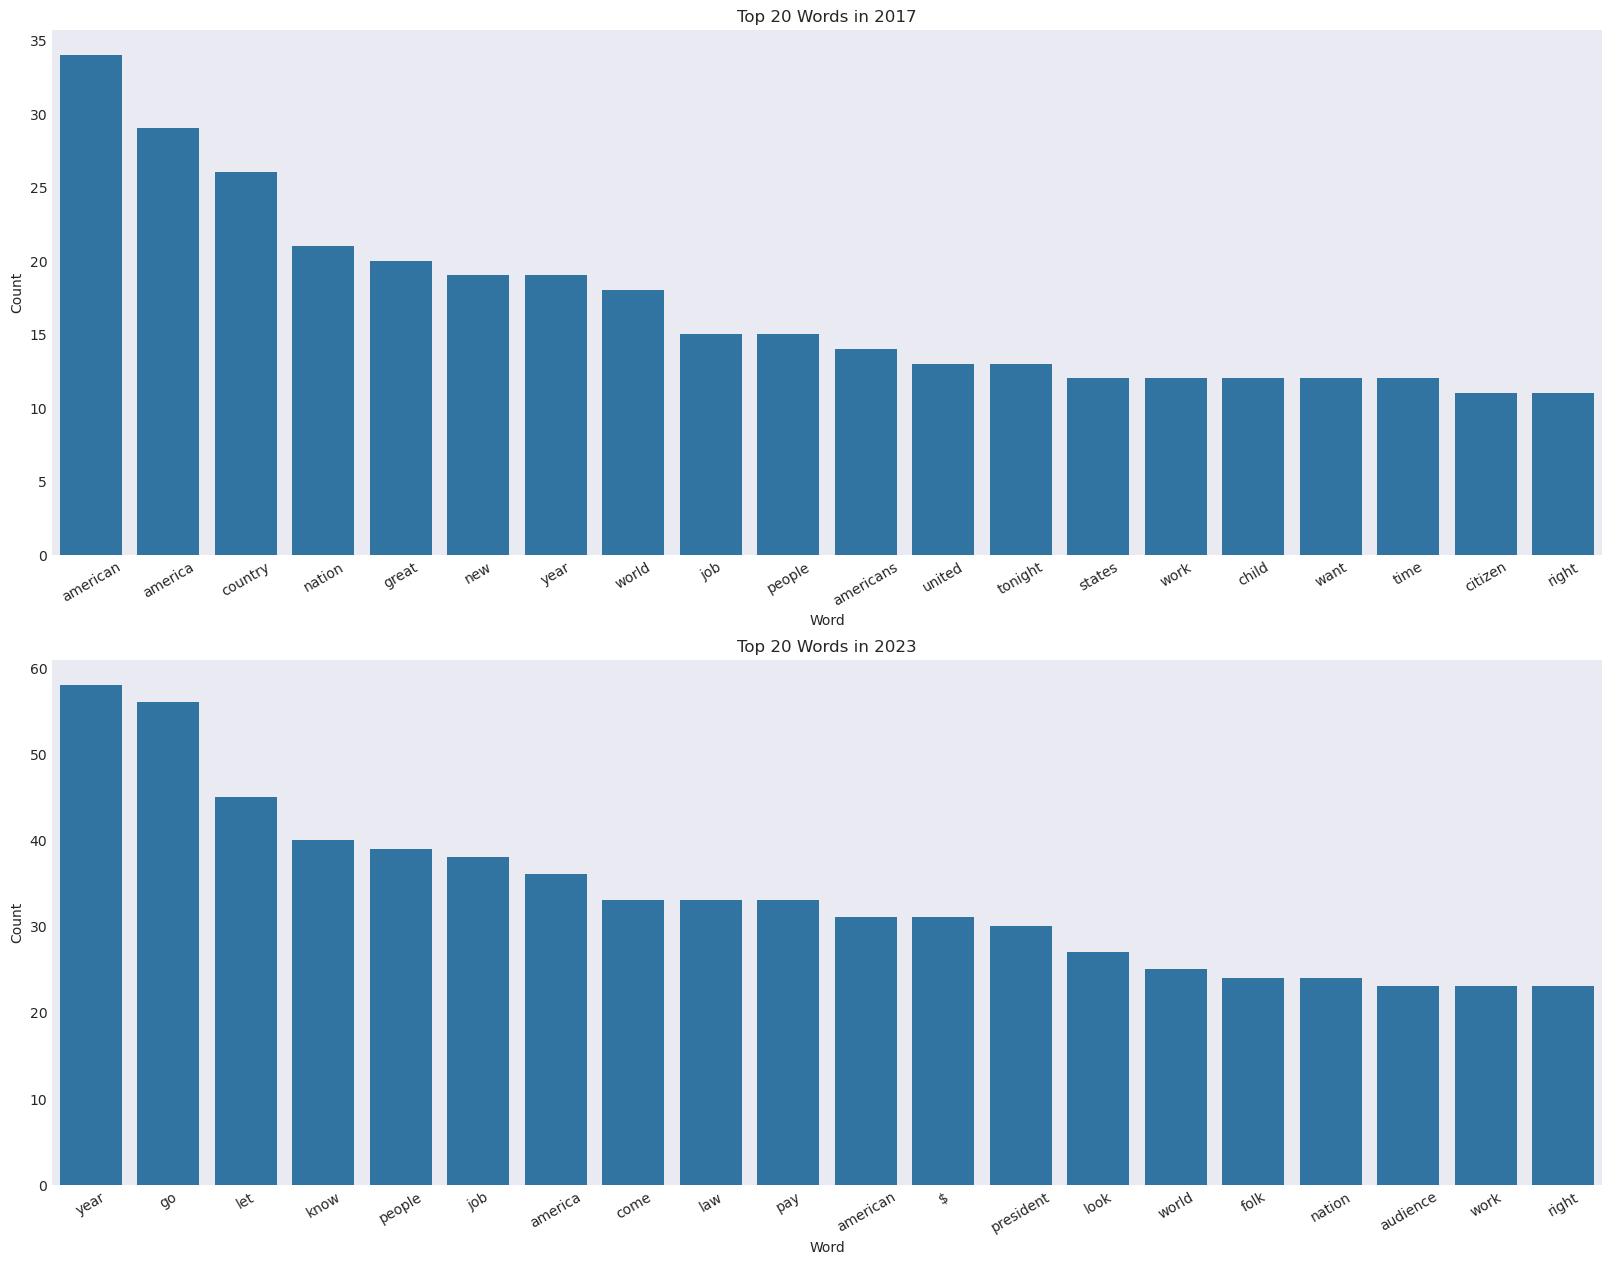

In [19]:
# Hint - use seaborn, subplots, and rotate tick labels
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

# 2017 Plot
sns.barplot(data=df_2017, x='Word', y='Count', ax=axes[0])
axes[0].set_title('Top 20 Words in 2017')

# 2023 Plot
sns.barplot(data=df_2023, x='Word', y='Count', ax=axes[1])
axes[1].set_title('Top 20 Words in 2023')

axes[0].tick_params("x", labelrotation=30)
axes[1].tick_params("x", labelrotation=30)
plt.show()

### TF-IDF Vectorization

To use statsitical alorithms on documents, we need to transform them into vectors, where each element of the vector corresponds to a particular word in a document or corpus of documents. One common way is via TF-IDF embeddings. LLMs work similarly - they typically use transformer models to generate text embeddings before sending text through a deep neural network. 

Here we will fit a TF-IDF vectorizer, plot all the speeches on a 2-D grid using PCA and also using a heatmap, and examine TF-IDF scores for the top 10 most common words in the first speech. This is a good resource here: https://medium.com/GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [31]:
# you may use this as input to fit the TF-IDF vectorizer
raw_docs = sou["Text"].to_list()

In [35]:
# Hint - use fit_transform for vectorizer and PCA
vectorizer = TfidfVectorizer()
vectorized_docs = vectorizer.fit_transform(raw_docs)


The output of `fit_transform()` will be a matrix where each row corresponds to a speech, each column corresponds to a word in the corpus of speeches, and the value is the TF-IDF score which measures the importance of that word in that speech, relative to the rest of the speeches.

#### Plot Speeches

- First used PCA to generate the first chart
- Second use seaborn heatmap with a log-scaled color axis to generate the second chart

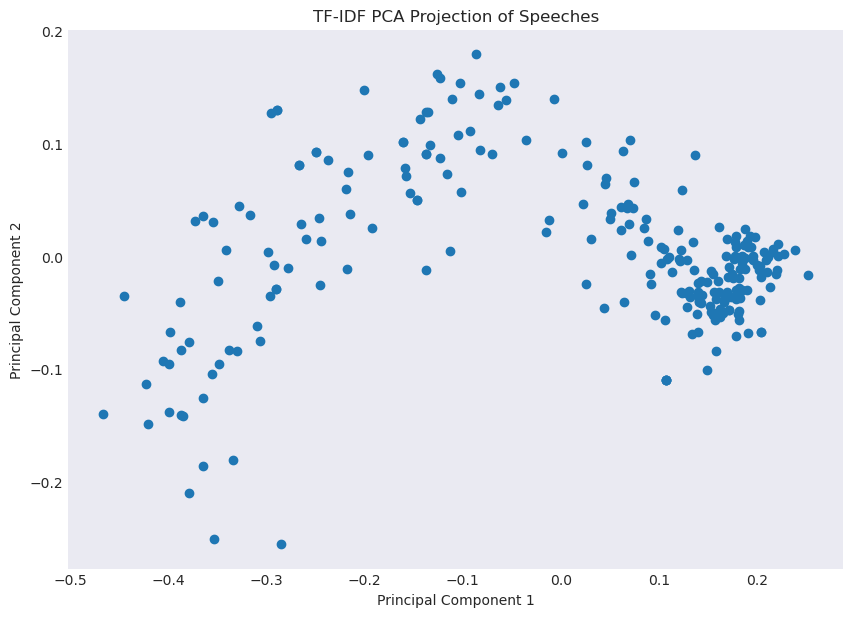

In [48]:
# Step 1: Set PCA to find first 2 principal components
pca = PCA(n_components=2)
coords = pca.fit_transform(vectorized_docs.toarray())
# Step 2: Create a new dataframe where each row is a speech, and each column is a projection onto
# one of the two principal components
pca_df = pd.DataFrame(coords, columns=["PC1", "PC2"])
pca_df["President"] = sou["President"].values
# Plot Data Visualization (Matplotlib)
plt.figure(figsize=(10, 7))
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("TF-IDF PCA Projection of Speeches")
plt.show()

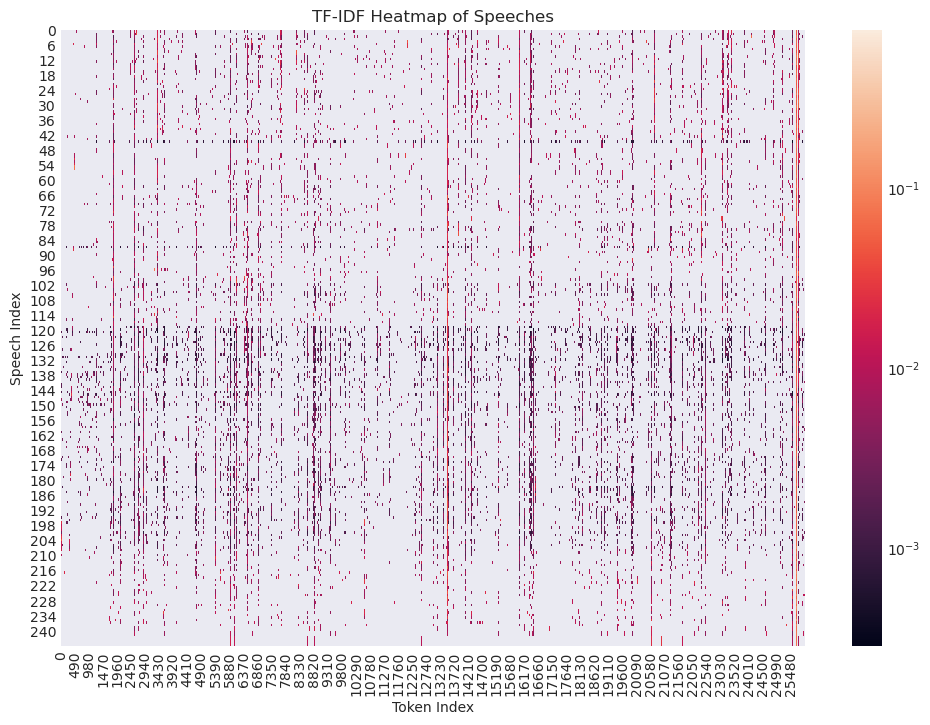

In [54]:
# Hint - vectorized_docs is a sparse matrix whose rows are speeches and columns are tokens, with each
# value being a TF-IDF score. Densify this array first, and then plot using seaborn.
from matplotlib.colors import LogNorm

vectorized_docs = vectorizer.fit_transform(raw_docs)
dense_matrix = vectorized_docs.todense()

plt.figure(figsize=(12, 8))
sns.heatmap(dense_matrix, norm=LogNorm())
plt.title("TF-IDF Heatmap of Speeches")
plt.xlabel("Token Index")
plt.ylabel("Speech Index")
plt.show()

#### Get the TF-IDF value for certain words and documents

In [55]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [56]:
word_nums = [vectorizer.vocabulary_[word] for word in word_list]  # get each word's index number using the .vocabular_ attributed of vectorizer

In [57]:
idf_score = [vectorizer.idf_[i] for i in word_nums] # get their IDF score by using .idf_ at the indices from the previous step

In [58]:
tf_idf = [vectorized_docs[0, i] for i in word_nums] # get the tf_idf score for the first speech

In [59]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438
